<a href="https://colab.research.google.com/github/shunitavni/Deep-Learning/blob/master/Prediction_based_on_Embedding_Representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tennis match prediction - Deep Learning

In this project I developed an algorithm that predicts the winner of a given Tennis match.

In order to do that, I will be working on two networks:
1. Embedding network - trained to predict a single outcome, given two players, in order to learn how to represent a player using a vector.
2. Prediction network - given two tennis player, this network predicts who is about to win. Each player is represented by a vector that is learned by the embedding network.

In [ ]:
import torch
import pandas as pd
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Dataset**

The dataset is composed of a collection of Tennis matches and their outcomes, provided in multiple files. You should download the data from https://drive.google.com/open?id=1ie6WSl8qkknpSGAFt32Gj7Tf0JAhTLu0 and place the folder somewhere in your Google drive. We provide you the following function *read_data_for_embedding_network*, which reads the files and create a few dictionaries that will help you handle the data later, and a list of instances for training the embedding network. Here is a detailed description of the output of this function:

1. player_names - this is a dictionary that maps between a player id and a player name. This player id is unique, and it is given by the dataset owners.
2. player_id2index - this is a dictionary that maps between a player id and an index (starting at 0). This index is unique, and it is created by us. It will help us represent the players with a one-hot vector later.
3. players_n - an integer representing the number of players we have in the data (this will be the length of a one-hot vector representing a player).
4. embedding_data - the dataset to train the embedding network. This dataset is a simple list of lists. Each internal list represents an individual training instance, coomposed of three components: the winner index, the loser index and a binary represnting who scored more aces (a serve that was not responded) during the match.

In [ ]:
def read_data_for_embedding_network(folder_path):
  player_names = {}
  player_id2index = {}
  players_n = 0
  embedding_data = []
  pathlist = Path(folder_path).glob('**/*.csv')
  for path in pathlist:
     path_in_str = str(path)
     print(path_in_str)
     raw = pd.read_csv(path_in_str, low_memory=False)
     for i, match in raw.iterrows():
      if match['winner_id'] not in player_names:
        player_names[match['winner_id']] = match['winner_name']
        player_id2index[match['winner_id']] = players_n
        players_n += 1
      if match['loser_id'] not in player_names:
        player_names[match['loser_id']] = match['loser_name']
        player_id2index[match['loser_id']] = players_n
        players_n += 1
      embedding_data.append([player_id2index[match['winner_id']], 
                             player_id2index[match['loser_id']], 
                            int(match['w_ace'] > match['l_ace'])])
  return player_names, player_id2index, players_n, embedding_data

#TODO - put your own path for the dataset folder
player_names, player_id2index, players_n, embedding_data = read_data_for_embedding_network('/content/drive/My Drive/atp-matches-dataset') 


/content/drive/My Drive/atp-matches-dataset/atp_matches_2000.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2002.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2001.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2004.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2003.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2006.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2005.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2007.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2008.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2009.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2010.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2013.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2011.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2012.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2015.csv
/content/drive/My Drive/a

**Embedding network**

Here I code the embedding network. An embedding network in general, is created for learning how to represent an input provided as a one-hot vector. It usually "projects" the one-hot vectors on another vector space, which has less dimensions that capture some meaningful information about the inputs. In this case, we will feed the network with the instances we got from the previous function: one hot vector to represent the winner, and ont hot vector to represent the loser. The network will try to predict who scored more aces. I  implement the network, based on the architecture depicted in the followin diagram. **Note - use ReLU activation, only after Linear 1.**

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vRp5PeqjF_W-gQmpjcY32hx4n5kWKsySdvLr3avz-bc0kodQbSlvNFuTBX6lcLzS6eS1nwjW0IdVCTY/pub?w=960&h=720)

In [ ]:
# TODO - complete the following network based on the diagram that's mentioned above.

class EmbeddingsNet(torch.nn.Module):

  def __init__(self, players_n, hidden_size):
    '''
      players_n - the size of the one hot vectors representing a single player
      hidden_size - the output size of Linear of winner, Linear of loser and Linear 1 from the diagram
      Note - Linear 2's output size should be 2
    '''
    super(EmbeddingsNet, self).__init__()
    self.players_n = players_n
    self.hidden_size = hidden_size
    self.linear_winner = nn.Linear(players_n,hidden_size)
    self.linear_loser = nn.Linear(players_n,hidden_size)
    self.linear1 = nn.Linear(2*hidden_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, 2) 

    
  def forward(self, player_1_batch, player_2_batch):
    '''
      player_1_batch - Bx(number of players) tensor - a batch of winner one hot vectors
      player_2_batch - Bx(number of players) tensor - a batch of loser one hot vectors
    '''
    winner_out = self.linear_winner(player_1_batch)
    loser_out = self.linear_loser(player_2_batch)
    x = torch.cat((winner_out, loser_out), dim=1)
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x

**Training the embedding network**

 Function that trains the embedding network.

In [ ]:
# Intializing the embedding network:
embedding_net = EmbeddingsNet(players_n, 200).cuda()
print(players_n)
print(embedding_net)

2053
EmbeddingsNet(
  (linear_winner): Linear(in_features=2053, out_features=200, bias=False)
  (linear_loser): Linear(in_features=2053, out_features=200, bias=False)
  (linear1): Linear(in_features=400, out_features=200, bias=False)
  (linear2): Linear(in_features=200, out_features=2, bias=False)
)


In [ ]:
# TODO - you should implement the following function. You should define 
# all the relevant tools required to train the network (e.g., optimizer, loss function) 
# inside this function. Please use Adam optimizer with default parameters.
# We suggest that you print the loss function every once in a while so that you 
# can watch the network improves. 

def train_embeddings_network(model, data, epochs, batch_size):
  '''
    model - the embedding_net object
    data - the dataset (i.e., embedding_data from above)
    epochs - number of epochs to train the network
    batch_size - the batch size
  '''
 
  trainloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        # get the inputs
        winner, loser, labels = data

        # For GPU
        winner = winner.cuda()
        loser = loser.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        one_hot_winner =F.one_hot(winner, model.players_n).float()
        one_hot_loser =F.one_hot(loser, model.players_n).float()

        # forward + backward + optimizer
        outputs = model(one_hot_winner, one_hot_loser)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if (i + 1) % 2000 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0






In [ ]:
# call the training procedure you implemented:
train_embeddings_network(embedding_net, embedding_data, 40, 8)

[1,  2000] loss: 0.594
[1,  4000] loss: 0.558
[1,  6000] loss: 0.545
[2,  2000] loss: 0.521
[2,  4000] loss: 0.528
[2,  6000] loss: 0.525
[3,  2000] loss: 0.507
[3,  4000] loss: 0.512
[3,  6000] loss: 0.516
[4,  2000] loss: 0.498
[4,  4000] loss: 0.504
[4,  6000] loss: 0.510
[5,  2000] loss: 0.492
[5,  4000] loss: 0.501
[5,  6000] loss: 0.499
[6,  2000] loss: 0.485
[6,  4000] loss: 0.486
[6,  6000] loss: 0.498
[7,  2000] loss: 0.477
[7,  4000] loss: 0.483
[7,  6000] loss: 0.488
[8,  2000] loss: 0.468
[8,  4000] loss: 0.478
[8,  6000] loss: 0.483
[9,  2000] loss: 0.459
[9,  4000] loss: 0.472
[9,  6000] loss: 0.476
[10,  2000] loss: 0.456
[10,  4000] loss: 0.468
[10,  6000] loss: 0.470
[11,  2000] loss: 0.450
[11,  4000] loss: 0.458
[11,  6000] loss: 0.463
[12,  2000] loss: 0.444
[12,  4000] loss: 0.453
[12,  6000] loss: 0.458
[13,  2000] loss: 0.439
[13,  4000] loss: 0.442
[13,  6000] loss: 0.447
[14,  2000] loss: 0.433
[14,  4000] loss: 0.435
[14,  6000] loss: 0.447
[15,  2000] loss: 0

**Extracting embeddings**

In this section, I extracted the player representation from the embedding network. In fact, we don't realy care about the quality of prediction of the embedding network. We care more about the vector representation it learned for every player. The representation is in fact the weight matrix of the two first linear layers that you created for each player of a given player pair. Each such weight matrix is of size (hidden_size X number_of_players). You can get that matrix of each of the two Linear layers, by calling their *parameters* function. This function returns a Python generator, and the first element is your matrix. Note that since you have two such layers, you will have two matrices; you are requested to add the two matrices together and divide by 2, and then you get a new matrix which will represent the players. This matrix, say M, will be of shape (hidden_size X number_of_players), so **M[:, 3]** for example, is a hidden_size vector representing player of index 3.

In [ ]:
# preparing the embedding matrix, let's call it player_embedding
params = embedding_net.parameters()
matricies = [param for param in params]
# weight matrix of the first two linear layers:
mat1=matricies[0]
mat2=matricies[2]
print("this is matrix shapes")
print("matrix size index 0 :" ,matricies[0].shape)
print("matrix size index 1 :" ,matricies[1].shape)
print("matrix size index 2 :" ,matricies[2].shape)
print("matrix size index 3 :" ,matricies[3].shape)
print("matrix size index 4 :" ,matricies[4].shape)
print("matrix size index 5 :" ,matricies[5].shape)
print("matrix size index 6 :" ,matricies[6].shape)
print("matrix size index 7 :" ,matricies[7].shape)


player_embedding = (mat1 + mat2)/2
print("Tensor size:" ,player_embedding.shape)
#print(player_embedding[:,3].shape)
print(player_embedding)   

this is matrix shapes
matrix size index 0 : torch.Size([200, 2053])
matrix size index 1 : torch.Size([200, 2053])
matrix size index 2 : torch.Size([200, 400])
matrix size index 3 : torch.Size([2, 200])


IndexError: ignored

**Prediction network**

Now, we are ready to implement a simple network that predicts who wins a match, given two players and some additional match-leavel features. Please implement PredictionNetwork based on the following diagram. Each player is provided with it's embedding from the player_embedding matrix you calculated above. **Note - use ReLU after every Linear layer (except the last one of course).**


![alt text](https://docs.google.com/drawings/d/e/2PACX-1vTCAlmaool-UQ9be8wSdjjgOq0VaCiYsXwsHw0HDxZRXTkp6vBm08Ma8sQha-cKDjjeZhfzY2qT8if8/pub?w=960&h=720)

In [ ]:
class PredictionNetwork(torch.nn.Module):
  def __init__(self, players_embedding_size, match_feature_size, hidden_size1, hidden_size2, hidden_size3):
    '''
      players_embedding_size - the length of the vector representing each player 
      (basically, the hidden_size of the embedding network)
      match_feature_size - the number of match-level features we use
      hidden_size1 - the output size of all the three first layers (Linear player 1, 
      Linear player 2, and Linear features)
      hidden_size2 - the output size of Linear 1
      hidden_size3 - the output size of Linear 2
    '''
    super(PredictionNetwork, self).__init__()
    self.players_embedding_size = players_embedding_size
    self.match_feature_size = match_feature_size
    self.hidden_size1= hidden_size1
    self.hidden_size2 = hidden_size2
    self.hidden_size3 = hidden_size3
    # net architecture:
    self.linear_player1 = nn.Linear(players_embedding_size,hidden_size1)
    self.linear_player2 = nn.Linear(players_embedding_size,hidden_size1)
    self.linear_feature = nn.Linear(match_feature_size,hidden_size1)
    self.linear1 = nn.Linear(3*hidden_size1,hidden_size2)
    self.linear2 = nn.Linear(hidden_size2,hidden_size3)
    self.linear3 = nn.Linear(hidden_size3,2)

  def forward(self, player1_batch, player2_batch, match_features_batch):
    '''
      player1_batch - Bx(players_embedding_size) tensor - a batch of player 1 embedding vectors
      player2_batch - Bx(players_embedding_size) tensor - a batch of player 2 embedding vectors
      match_features_batch - Bx(match_feature_size) tensor - a batch of match-level features
    ''' 
    player1_batch = F.relu(self.linear_player1(player1_batch))
    player2_batch = F.relu(self.linear_player2(player2_batch))
    match_features_batch = F.relu(self.linear_feature(match_features_batch))
    # concat the 3 linear layers into 1 dimension vector
    x=torch.cat((player1_batch,player2_batch,match_features_batch),1)
    x=F.relu(self.linear1(x))
    x=F.relu(self.linear2(x))
    x=self.linear3(x)
    return x


The following function, **prepare_match_dataset**, prepares the dataset of instances required to train your prediction network. We randomize the position of the winner and loser in each instance, to avoid converging to position based prediction. As you can see, we only use only a single match-level feature for now: draw_size.

In [ ]:
def prepare_match_dataset(folder_path, player_embedding):
  X = []
  y = []
  surface_dictionary = {}
  pathlist = Path(folder_path).glob('**/*.csv')
  for path in pathlist:
    path_in_str = str(path)
    print(path_in_str)
    raw = pd.read_csv(path_in_str, low_memory=False)
    for i, match in raw.iterrows():
      instance = []
      features = []
      features.append(match['draw_size'])
      winner_embedding = player_embedding[:, player_id2index[match['winner_id']]].cpu().detach().numpy()
      loser_embedding = player_embedding[:, player_id2index[match['loser_id']]].cpu().detach().numpy()
      target = -1
      if random.random() < 0.5:
         instance.append(winner_embedding)
         instance.append(loser_embedding)
         target = 0
      else:
         instance.append(loser_embedding)
         instance.append(winner_embedding)
         target = 1
      instance.append(features)
      X.append(instance)
      y.append(target)


  return X, y


#TODO - put your own path for the dataset folder
X, y = prepare_match_dataset('/content/drive/My Drive/atp-matches-dataset', player_embedding) 


/content/drive/My Drive/atp-matches-dataset/atp_matches_2000.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2002.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2001.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2004.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2003.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2006.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2005.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2007.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2008.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2009.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2010.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2013.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2011.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2012.csv
/content/drive/My Drive/atp-matches-dataset/atp_matches_2015.csv
/content/drive/My Drive/a

**Training the prediction network**

Now, you should write code to train the prediction network using the X,y dataset.

In [ ]:
# TODO - split the data into train and test. Please allocate 25% of the data for test, using random_state=42
# X = data the players
# y = labels 0/1 ( win or lose )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
# TODO - you should implement the following train_match_network function. You should define 
# all the relevant tools required to train the network (e.g., optimizer, loss function) 
# inside this function. Please use Adam optimizer with default parameters.
# You should print and plot the loss function for the train data every once in a while, 
# as well as accuracy for the test data (every epoch) so that you 
# can watch the network improves.


# Student's note:
# It is not clear whether we should also PLOT the loss and accuracy "once in a while".
# We have thus decided to only print it, and then plot it after the training ends.

# Accuracy function
def Calculate_Accuracy(testloader,model,epoch):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
        # get the inputs
        inputs, labels = data
        # for GPU
        players1=inputs[0].cuda()
        players2=inputs[1].cuda()
        feature=inputs[2][0].cuda()
        labels = labels.cuda()

        # create 1 vector array in 'match_feature_size' size and match data
        feature = feature.reshape(-1,model.match_feature_size).float()
        
        # calculate accuracy
        outputs = model(players1,players2,feature)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  accuracy = (100 * correct / total);
  #print accuracy per epoch
  print('Epoch %d Accuracy: %d %%' % (epoch+1,accuracy )) 
  return accuracy;

def train_match_network(model, X_train, X_test, y_train, y_test, epochs, batch_size):
  '''
    X_train - the training data
    X_test - the testing data
    y_train - the target of the training data
    y_test - the target of the testing data
    epochs - number of epochs
    batch_size - the batch size
  '''
  train_data=[[x,y] for x,y in zip(X_train,y_train)]
  test_data=[[x,y] for x,y in zip(X_test,y_test)]
  trainloader=torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  testloader=torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

  # define the loss arrays
  train_loss = []
  accuracy = []

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    running_loss = 0.0
    epoch_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # for GPU
        players1 =inputs[0].cuda()
        players2 =inputs[1].cuda()
        feature = inputs[2][0].cuda()
        labels = labels.cuda()

        # create 1 vector array in 'match_feature_size' size and match data
        feature = feature.reshape(-1,model.match_feature_size).float()

        # Zero the gradients
        optimizer.zero_grad()

        # Get the model's output
        outputs = model(players1,players2,feature)

        # Define the loss
        loss = criterion(outputs, labels)

        # Calculate the gradients
        loss.backward()

        # Take an optimizer step
        optimizer.step()

        # Rolling loss
        running_loss += loss.item()
        epoch_loss += loss.item()

        # Print the batch loss every 2000th batch
        # if((i+1) % 2000 == 0):
        #   print('[%d, %5d] loss: %.3f' %
        #     (epoch + 1, (i + 1), running_loss / (i+1)))

        if((i+1) % 2000 == 0):
          print('[%d, %5d] loss: %.3f' %
            (epoch + 1, (i + 1), running_loss / 2000))
          running_loss = 0.0

    # Calculate the accuracy on the test set
    accuracy.append(Calculate_Accuracy(testloader,model,epoch))

    # Add the epoch's loss
    train_loss.append(epoch_loss / len(trainloader))

  return train_loss,accuracy

In [ ]:
# TODO - train your network
tennisMatchModel = PredictionNetwork(200, 1, 1024, 700, 200).cuda()
train_loss,accuracy = train_match_network(tennisMatchModel, X_train, X_test, y_train, y_test, 40, 2)

[1,  2000] loss: 0.797
[1,  4000] loss: 0.732
[1,  6000] loss: 0.695
[1,  8000] loss: 0.695
[1, 10000] loss: 0.706
[1, 12000] loss: 0.724
[1, 14000] loss: 0.696
[1, 16000] loss: 0.694
[1, 18000] loss: 0.695
Epoch 1 Accuracy: 50 %
[2,  2000] loss: 0.694
[2,  4000] loss: 0.692
[2,  6000] loss: 0.694
[2,  8000] loss: 0.692
[2, 10000] loss: 0.696
[2, 12000] loss: 0.690
[2, 14000] loss: 0.693
[2, 16000] loss: 0.688
[2, 18000] loss: 0.693
Epoch 2 Accuracy: 50 %
[3,  2000] loss: 0.684
[3,  4000] loss: 0.688
[3,  6000] loss: 0.683
[3,  8000] loss: 0.692
[3, 10000] loss: 0.691
[3, 12000] loss: 0.690
[3, 14000] loss: 0.691
[3, 16000] loss: 0.688
[3, 18000] loss: 0.691
Epoch 3 Accuracy: 50 %
[4,  2000] loss: 0.683
[4,  4000] loss: 0.684
[4,  6000] loss: 0.687
[4,  8000] loss: 0.686
[4, 10000] loss: 0.685
[4, 12000] loss: 0.681
[4, 14000] loss: 0.680
[4, 16000] loss: 0.684
[4, 18000] loss: 0.681
Epoch 4 Accuracy: 56 %
[5,  2000] loss: 0.679
[5,  4000] loss: 0.663
[5,  6000] loss: 0.661
[5,  8000] 

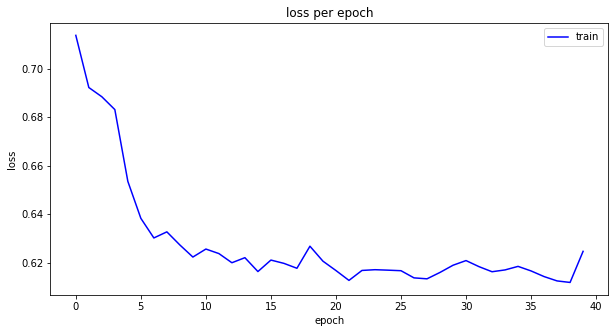

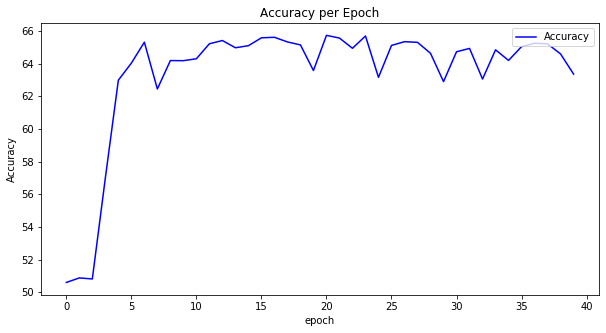

In [ ]:
# ---------------------------------------------- #
#                     Loss
# ---------------------------------------------- #
  plt.figure(figsize=(10,5))
  plt.plot(train_loss ,label = 'train',c ='blue')
  #plt.plot(x, test_loss,label = 'test',c='red')
  plt.title('loss per epoch')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(loc='upper right')
  plt.show()

# ---------------------------------------------- #
#                     Accuracy
# ---------------------------------------------- #
  plt.figure(figsize=(10,5))
  plt.plot(accuracy,label = 'Accuracy',c ='blue')
  plt.title('Accuracy per Epoch')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='upper right')
  plt.show()
